# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [52]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt
import time

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4    # D
hidden_size = 10  # H
num_classes = 3   # C
num_inputs = 5    # N

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [3]:
W1, b1 = net.params['W1'], net.params['b1']
W2, b2 = net.params['W2'], net.params['b2']
N, D = X.shape
H, C = W2.shape

mask = np.eye(C, dtype=bool)[y]
mask

array([[ True, False, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False]])

In [4]:
b1 * b1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
A = X.dot(W1) + b1
H = np.maximum(A, 0)
S = H.dot(W2) + b2
# S -= np.max(S, axis=1)[:,np.newaxis]
P = np.exp(S) / np.sum(np.exp(S), axis=1)[:,np.newaxis]


In [6]:
H.shape

(5, 10)

In [7]:
loss = -1.0/N * np.sum(np.log(P[mask]))
loss

1.2658570521180534

In [8]:
ones_yi = mask.astype(float)
dS = P - ones_yi


In [9]:
np.sum(dS, axis=0) + 2*b2

array([ 1.04984549, -0.7159525 , -0.33389299])

In [10]:
W2.shape

(10, 3)

In [11]:
dS.shape

(5, 3)

In [12]:
h = H[1,:]
ds = dS[1,:]
h, ds

(array([0.        , 0.        , 1.27951663, 1.87210399, 4.81975823,
        0.        , 0.        , 0.        , 2.15938324, 5.11493888]),
 array([ 0.47590629, -0.82782961,  0.35192332]))

In [13]:
h[:, np.newaxis]

array([[0.        ],
       [0.        ],
       [1.27951663],
       [1.87210399],
       [4.81975823],
       [0.        ],
       [0.        ],
       [0.        ],
       [2.15938324],
       [5.11493888]])

In [14]:
ds

array([ 0.47590629, -0.82782961,  0.35192332])

In [15]:
W2

array([[-0.1048553 , -0.14200179, -0.17062702],
       [ 0.19507754, -0.05096522, -0.04380743],
       [-0.12527954,  0.07774904, -0.16138978],
       [-0.02127403, -0.08954666,  0.03869025],
       [-0.05108051, -0.11806322, -0.00281822],
       [ 0.04283319,  0.00665172,  0.03024719],
       [-0.06343221, -0.03627412, -0.06724604],
       [-0.03595532, -0.08131463, -0.17262826],
       [ 0.01774261, -0.04017809, -0.16301983],
       [ 0.04627823, -0.09072984,  0.00519454]])

In [16]:
h[:, np.newaxis]*ds

array([[ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.60893002, -1.05922175,  0.45029174],
       [ 0.89094607, -1.54978312,  0.65883705],
       [ 2.29375327, -3.98993857,  1.6961853 ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 1.02766407, -1.78760138,  0.75993731],
       [ 2.4342316 , -4.23429785,  1.80006625]])

In [17]:
H.T.dot(dS)

array([[-2.51639581,  0.90716554,  1.60923026],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.52378564,  0.55560995, -2.07939559],
       [-1.15496836,  0.97621433,  0.17875403],
       [ 3.91641424, -1.71213352, -2.20428071],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.32661846, -0.60884513,  0.28222667],
       [ 3.15139842, -0.40192272, -2.74947571],
       [ 4.42353586, -2.97818182, -1.44535404]])

In [18]:
dH = dS.dot(W2.T)

In [19]:
dA = np.where(A>0, dH, 0)

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [20]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularization loss.

In [21]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7963408538435033e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [22]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    # print(param_name, 'shape', param_grad_num.shape)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 3.865091e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 1.555470e-09
W1 max relative error: 3.561318e-09


In [23]:
# for param_name in grads:
#     print(param_name, 'shape', grads[param_name].shape)

# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.02.

Final training loss:  0.017149672727854864


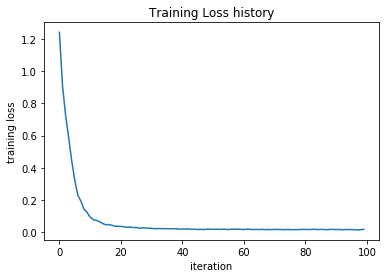

In [24]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [25]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [53]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=2000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 2000: loss 2.303004
iteration 100 / 2000: loss 2.302493
iteration 200 / 2000: loss 2.299028
iteration 300 / 2000: loss 2.258280
iteration 400 / 2000: loss 2.195415
iteration 500 / 2000: loss 2.086933
iteration 600 / 2000: loss 2.021332
iteration 700 / 2000: loss 2.047393
iteration 800 / 2000: loss 2.075198
iteration 900 / 2000: loss 1.912055
iteration 1000 / 2000: loss 2.036867
iteration 1100 / 2000: loss 1.959574
iteration 1200 / 2000: loss 1.953731
iteration 1300 / 2000: loss 1.859839
iteration 1400 / 2000: loss 1.958012
iteration 1500 / 2000: loss 1.895259
iteration 1600 / 2000: loss 1.752737
iteration 1700 / 2000: loss 1.745071
iteration 1800 / 2000: loss 1.838119
iteration 1900 / 2000: loss 1.792901
Validation accuracy:  0.364


In [44]:
stats.keys()

dict_keys(['loss_history', 'train_acc_history', 'val_acc_history'])

In [45]:
stats['val_acc_history']

[0.106, 0.201, 0.224, 0.25, 0.286, 0.301, 0.322, 0.34, 0.36]

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

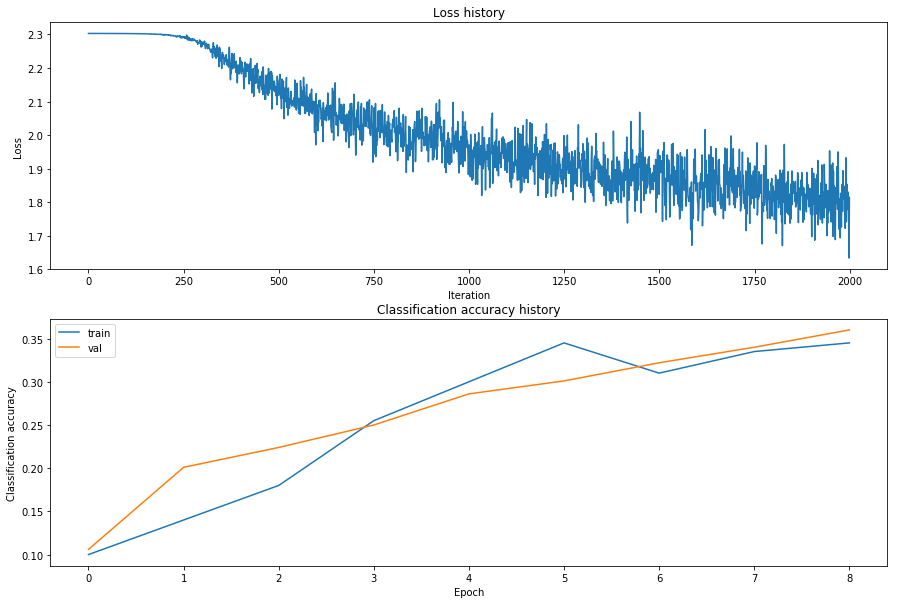

In [49]:
def plot_stats(stats):
    # Plot the loss function and train / validation accuracies
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()

plot_stats(stats)

0.48500000000000004

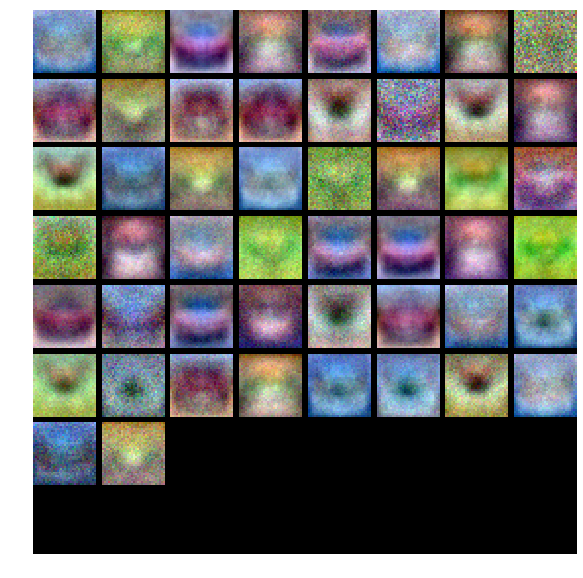

In [47]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including:
 - hidden layer size
 - learning rate
 - numer of training epochs
 - regularization strength

You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit Your Answer:}$

Starting hyperparameter search...



=== PARAMETERS ===   lr= 0.002    reg= 0.03
Training  took 21.855635s


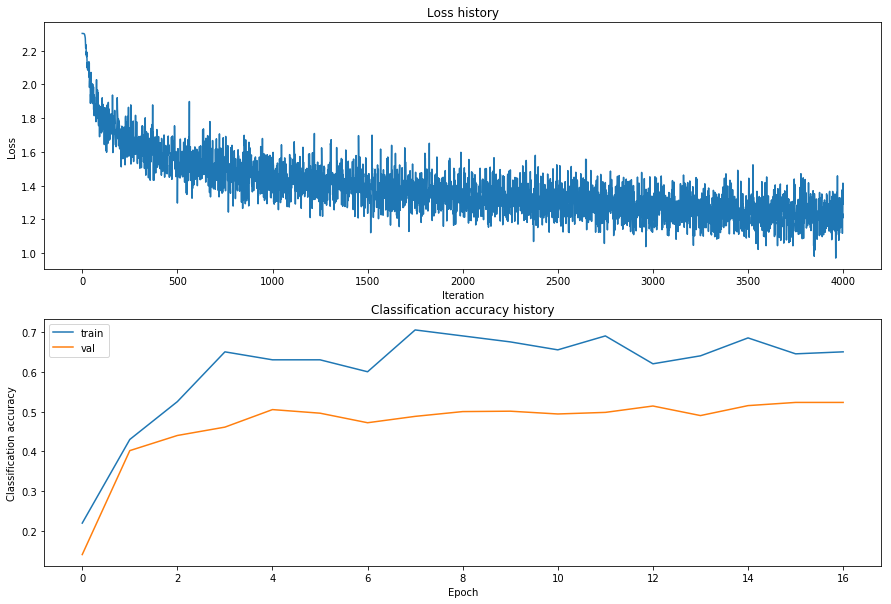

training_accuracy = 0.66
validation_accuracy = 0.5203333333333333



=== PARAMETERS ===   lr= 0.002    reg= 0.1
Training  took 21.042871s


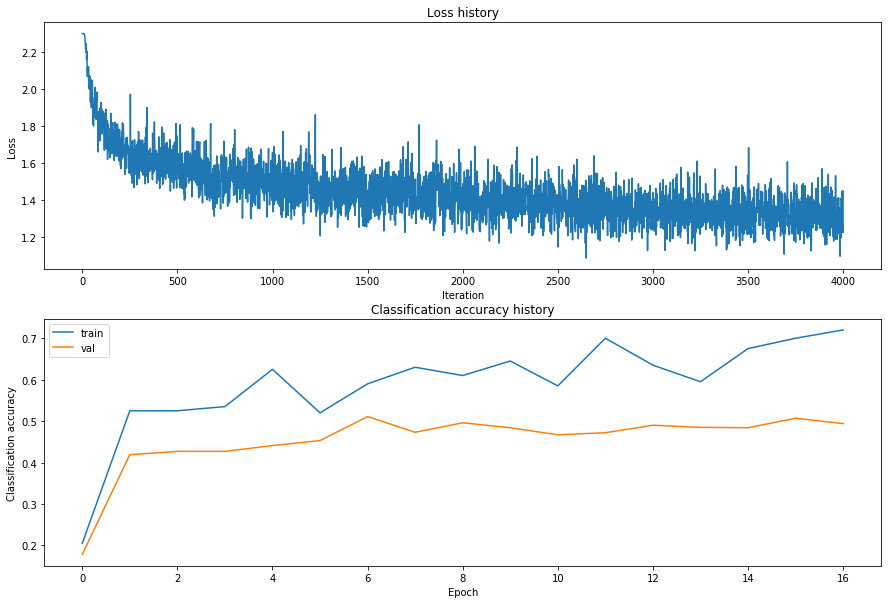

training_accuracy = 0.6983333333333333
validation_accuracy = 0.49499999999999994



=== PARAMETERS ===   lr= 0.002    reg= 3
Training  took 21.339750s


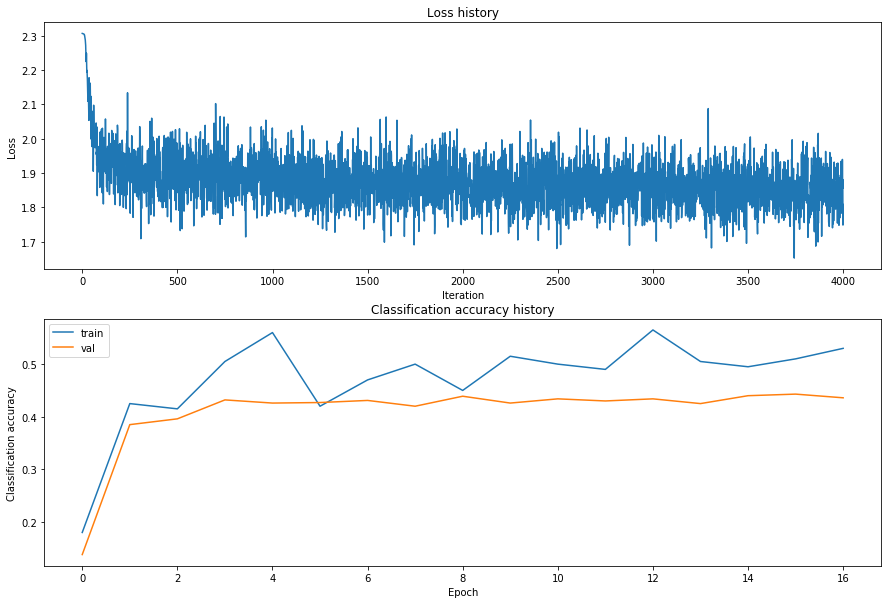

training_accuracy = 0.5116666666666666
validation_accuracy = 0.43966666666666665



=== PARAMETERS ===   lr= 0.001    reg= 0.03
Training  took 25.888594s


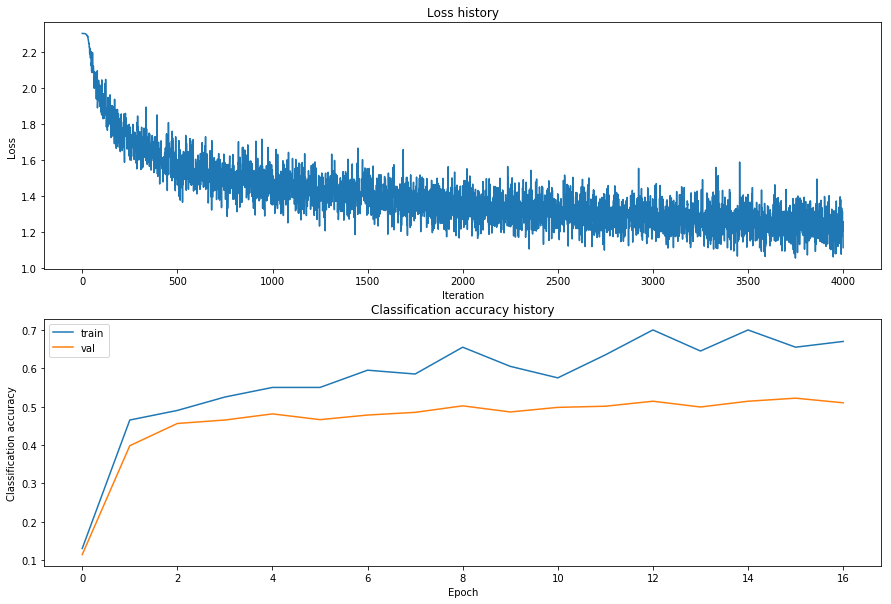

training_accuracy = 0.6749999999999999
validation_accuracy = 0.5153333333333333



=== PARAMETERS ===   lr= 0.001    reg= 0.1
Training  took 22.660718s


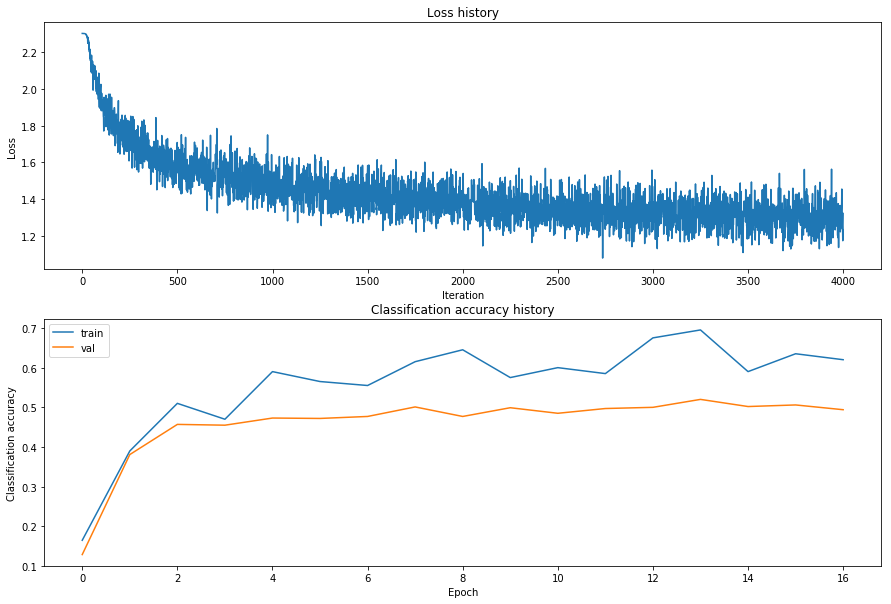

training_accuracy = 0.6150000000000001
validation_accuracy = 0.5006666666666667



=== PARAMETERS ===   lr= 0.001    reg= 3
Training  took 22.773319s


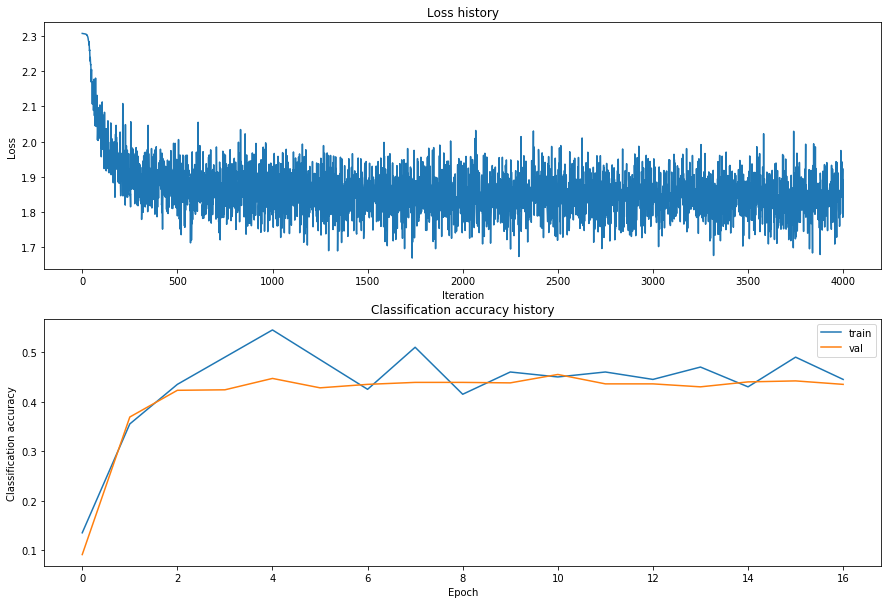

training_accuracy = 0.455
validation_accuracy = 0.439



=== PARAMETERS ===   lr= 0.0001    reg= 0.03
Training  took 24.332006s


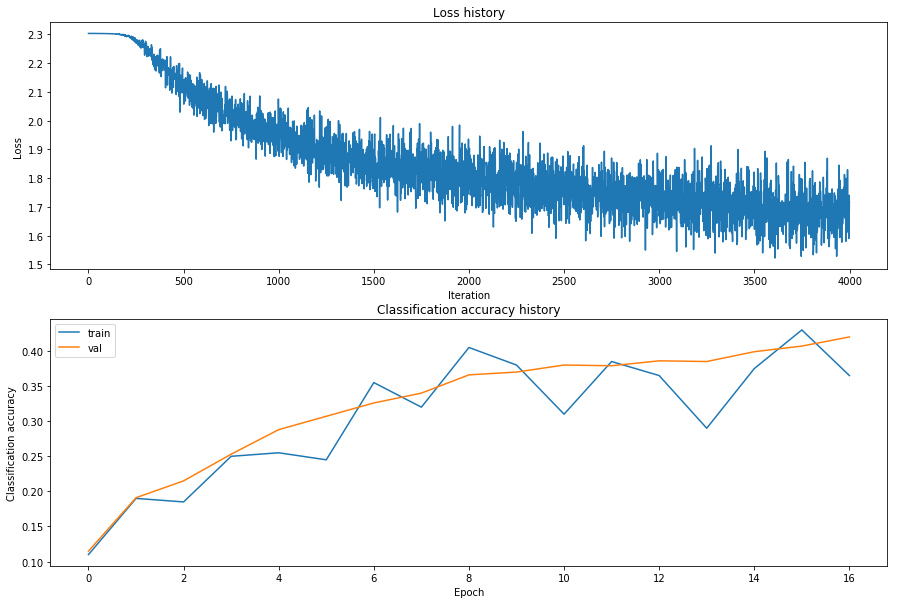

training_accuracy = 0.38999999999999996
validation_accuracy = 0.4086666666666667



=== PARAMETERS ===   lr= 0.0001    reg= 0.1
Training  took 27.341419s


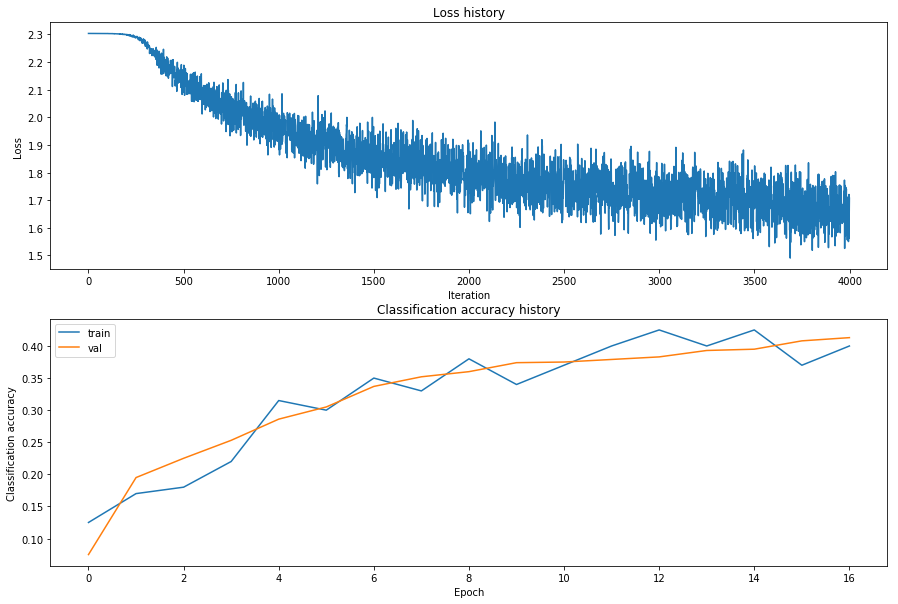

training_accuracy = 0.39833333333333326
validation_accuracy = 0.4053333333333333



=== PARAMETERS ===   lr= 0.0001    reg= 3
Training  took 25.974015s


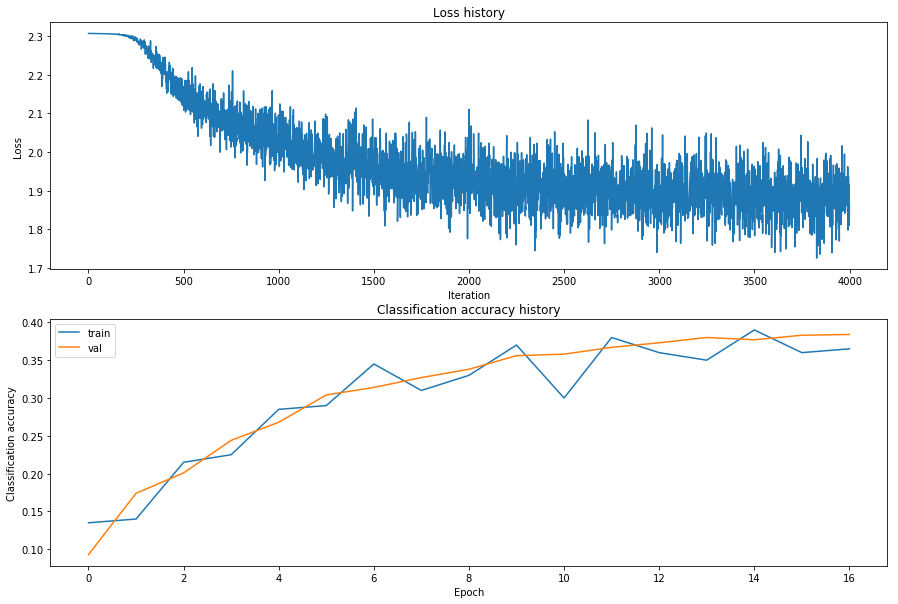

training_accuracy = 0.37166666666666665
validation_accuracy = 0.38133333333333336


In [62]:


from cs231n.classifiers.neural_net import TwoLayerNet
results = {}
best_val = -1
best_net = None # store the best model into this 



input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10



#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [2e-3, 1e-3, 1e-4]
regularization_strengths = [0.03, 0.1, 3]


print("Starting hyperparameter search...")
NUM_ITERATIONS = 4000
PRINT_LOSS_HISTORY = True

for lr in learning_rates:
    for reg in regularization_strengths:
        
        print('\n\n')
        print('=== PARAMETERS ===', '  lr=', lr, '   reg=', reg)

        tic = time.time()
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=NUM_ITERATIONS,
                    batch_size=200,
                    learning_rate_decay=0.95,
                    learning_rate=lr,
                    reg=reg,
                    verbose=False)
        toc = time.time()
        print('Training  took %fs' % (toc - tic))


        if PRINT_LOSS_HISTORY:
            plot_stats(stats)

        # evaluate
        training_accuracy = np.average(stats['train_acc_history'][-3:])
        validation_accuracy = np.average(stats['val_acc_history'][-3:])
        print('training_accuracy =', training_accuracy)
        print('validation_accuracy =', validation_accuracy)
        
        
        # store results
        results[(lr,reg)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_net = net


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [65]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-04 reg 3.000000e-02 train accuracy: 0.390000 val accuracy: 0.408667
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.398333 val accuracy: 0.405333
lr 1.000000e-04 reg 3.000000e+00 train accuracy: 0.371667 val accuracy: 0.381333
lr 1.000000e-03 reg 3.000000e-02 train accuracy: 0.675000 val accuracy: 0.515333
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.615000 val accuracy: 0.500667
lr 1.000000e-03 reg 3.000000e+00 train accuracy: 0.455000 val accuracy: 0.439000
lr 2.000000e-03 reg 3.000000e-02 train accuracy: 0.660000 val accuracy: 0.520333
lr 2.000000e-03 reg 1.000000e-01 train accuracy: 0.698333 val accuracy: 0.495000
lr 2.000000e-03 reg 3.000000e+00 train accuracy: 0.511667 val accuracy: 0.439667
best validation accuracy achieved during cross-validation: 0.520333


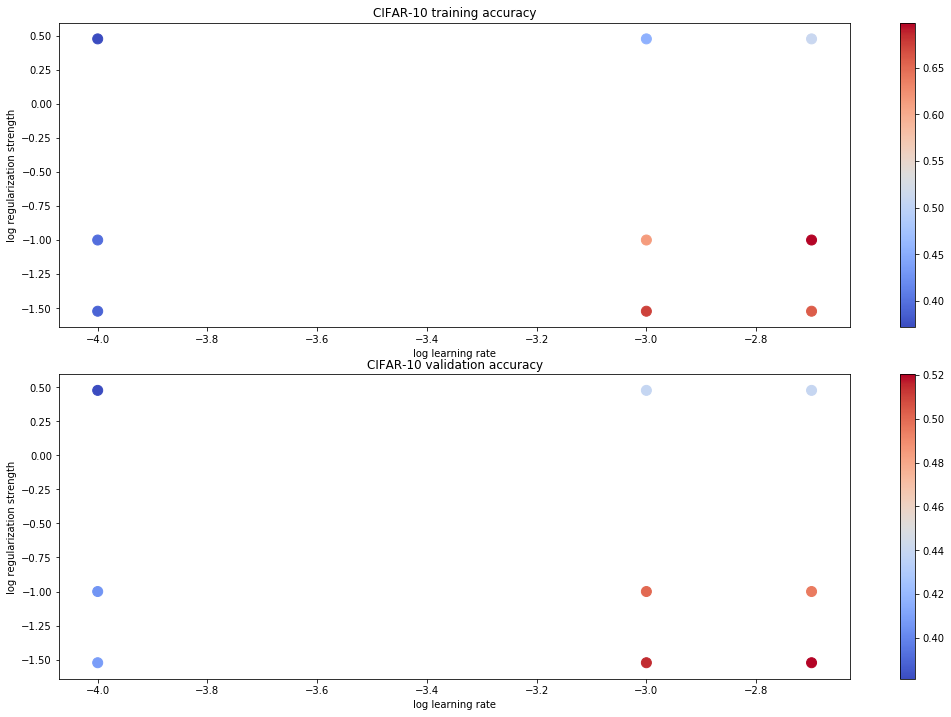

In [70]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [71]:
# Print your validation accuracy: this should be above 48%
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.504


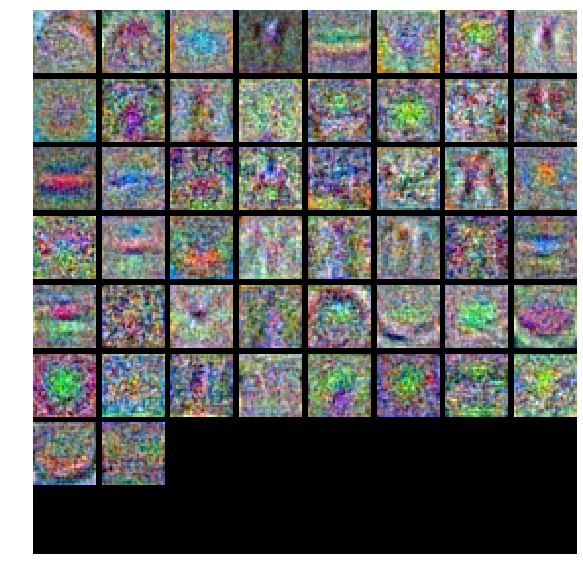

In [73]:
# Visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [74]:
# Print your test accuracy: this should be above 48%
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.492


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 1, 2, 3.

$\color{blue}{\textit Your Explanation:}$

